In [ ]:
from util import * 

# Plot parameters 
plt.rcParams.update({
    "font.family": "georgia",
    'text.latex.preamble': r'\\usepackage{amsmath}',
    'mathtext.fontset': 'cm',
})

# Making some testing data (edit this to test at different temps)
test_temp = 850
Xtest = np.linspace(0.6, 1.4, 250).reshape(-1,1)
Xtest = np.hstack(
    (Xtest, np.ones((Xtest.shape[0], 1))*test_temp)
)

# Levels of fidelity
K = 5 

# Temperature vector 
temps = [450, 550, 650, 750, 850]

# Initializing data dict
data_dict = {} 
for level in range(K):
    data_dict[level] = {
        'X':jnp.array([[]]), 
        'Y':jnp.array([[]])
    }

# Loading the Cantera data at each temperature profile
for temp in temps:
    # Loading the data
    with open("data/FlameSpeedData%d.pkl" % temp, 'rb') as infile:
        temp_dict = pickle.load(infile)

    # Iterating through the levels of fidelity
    for level in temp_dict.keys():
        # Obtaining the number of samples
        N = temp_dict[level]['X'].shape[0]
        
        # Getting X and Y matrices
        X, Y = temp_dict[level]['X'], temp_dict[level]['Y']

        # I had two data points that were glitched out with super high LFS values, so I corrected for that here 
        Y[Y > 100] *= 1/700

        # Populating the master data dictionary with the training data at each temperature
        data_dict[level]['X'] = jnp.vstack(
            (data_dict[level]['X'].reshape(-1,2), X)
        )
        data_dict[level]['Y'] = jnp.vstack(
            (data_dict[level]['Y'].reshape(-1,1), jnp.log(Y).reshape(-1,1))
        )

# Filtering out the high-fidelity data 
test_inds = (data_dict[4]['X'][:,1] == test_temp )
Xtrue, Ytrue = data_dict[4]['X'][test_inds,:], data_dict[4]['Y'][test_inds]
inds = (data_dict[4]['X'][:,1] <600)
data_dict[4]['X'], data_dict[4]['Y'] = data_dict[4]['X'][inds,:], data_dict[4]['Y'][inds]

# Standard Scaling each set of training and testing inputs 
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
data_dict[0]['X'] = scaler.fit_transform(data_dict[0]['X'])
for i in range(1,K):
    data_dict[i]['X'] = scaler.transform(data_dict[i]['X'])
Xtest = scaler.transform(Xtest)

# Initializing noise vars
for level in data_dict.keys():
    data_dict[level]['noise_var'] = 1e-5


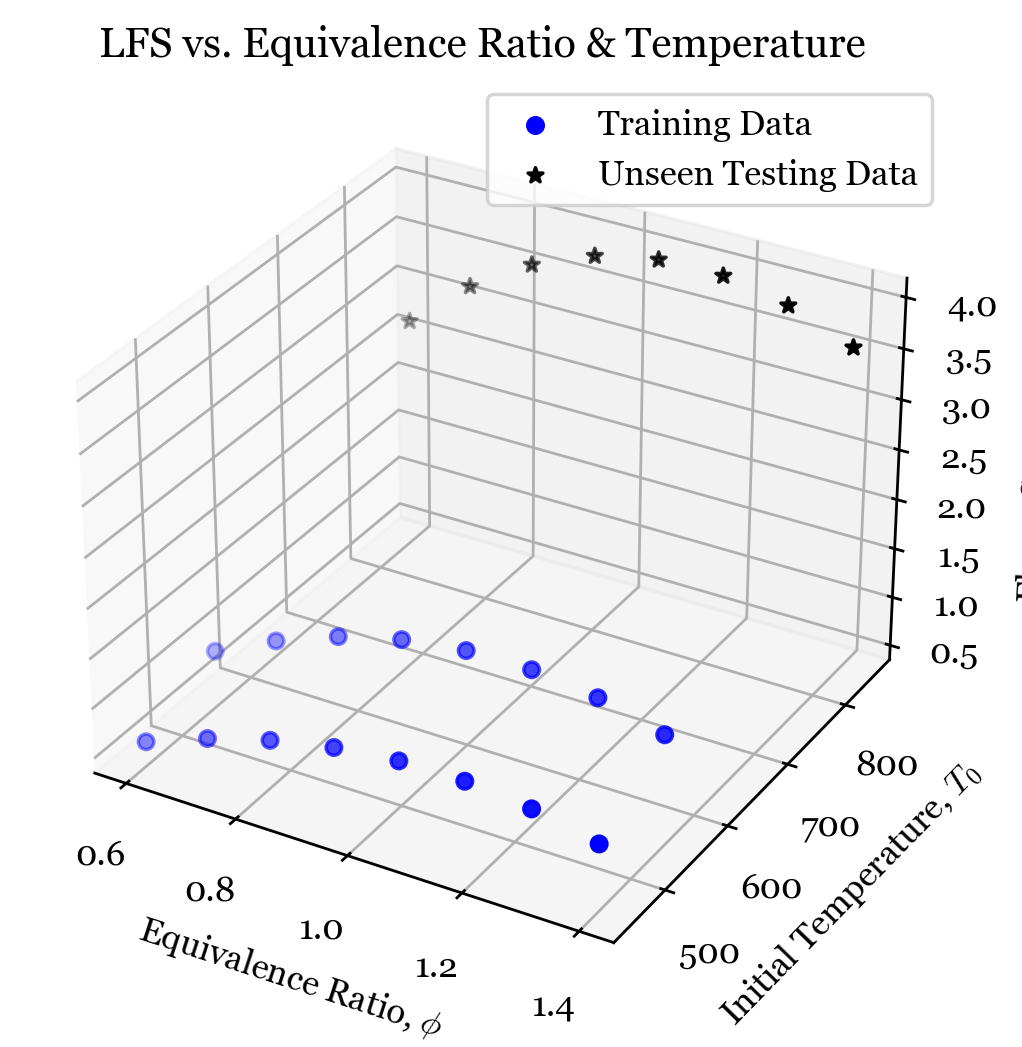

In [2]:
# Plotting a three-dimensional scatterplot of the training and testing high-fidelity data
fig = plt.figure(dpi=250)
ax = fig.add_subplot(111, projection='3d')

level = 4
ax.scatter(scaler.inverse_transform(data_dict[level]['X'])[:,0], scaler.inverse_transform(data_dict[level]['X'])[:,1], jnp.exp(data_dict[level]['Y']).ravel(), c='blue', marker='o', label = 'Training Data')
ax.scatter(Xtrue[:,0],Xtrue[:,1], jnp.exp(Ytrue).ravel(), marker = '*', c = 'black', label = "Unseen Testing Data")

ax.set_xlabel('Equivalence Ratio, $\phi$')
ax.set_ylabel('Initial Temperature, $T_0$')
ax.set_zlabel('Flame Speed (m/s)')
ax.legend()

plt.title('LFS vs. Equivalence Ratio & Temperature ')
plt.savefig('HFData.png')

In [3]:
# Instantiating the Hyperkriging model 
model  = Hyperkriging(
    data_dict, rbf, 3, jitter = 1e-6
)

In [ ]:
# Training GP-surrogate for lowest level of fidelity 
model.optimize(0, params_to_optimize = ['k_param'], lr = 1e-5, epochs = 250, beta1 = 0.9, beta2 = 0.999, batch_size = 250, shuffle = False)

100%|██████████| 250/250 [00:09<00:00, 26.64it/s, Loss: -1.57642, LR: 1.00e-05]   


In [5]:
# Training GP-surrogate for fidelity-1 data 
model.optimize(1, params_to_optimize = ['k_param'], lr = 1e-5, epochs = 250, beta1 = 0.9, beta2 = 0.999, batch_size = 250, shuffle = False)

100%|██████████| 250/250 [00:06<00:00, 39.65it/s, Loss: -450.69580, LR: 1.00e-05] 


In [7]:
# Training GP-surrogate for fidelity-2 data 
model.optimize(2, params_to_optimize = ['k_param'], lr = 1e-3, epochs = 250, beta1 = 0.9, beta2 = 0.999, batch_size = 250, shuffle = False)

100%|██████████| 250/250 [00:02<00:00, 95.20it/s, Loss: -1131.26331, LR: 1.00e-03] 


In [11]:
# Training GP-surrogate for fidelity-3 data 
model.optimize(3, params_to_optimize = ['k_param'], lr = 1e-2, epochs = 250, beta1 = 0.9, beta2 = 0.999, batch_size = 250, shuffle = False)

100%|██████████| 250/250 [00:02<00:00, 96.37it/s, Loss: -668.53796, LR: 1.00e-02] 


In [23]:
# Training GP-surrogate for High-Fidelity Data
# NOTE: This will likely take thousands of iterations to converge than the other levels... it is iterating through a higher-dimensional parameter space with less data which makes the optimization problem harder
model.optimize(4, params_to_optimize = ['k_param'], lr = 1e-1, epochs = 5000, beta1 = 0.9, beta2 = 0.999, batch_size = 250, shuffle = False)

100%|██████████| 5000/5000 [01:13<00:00, 68.41it/s, Loss: -125.16367, LR: 1.00e-01]


In [25]:
# Making the Hyperkriging predictions at the testing data 
mean, cov = model.predict(Xtest, 4) 
conf = 2 * np.sqrt(np.diag(cov))

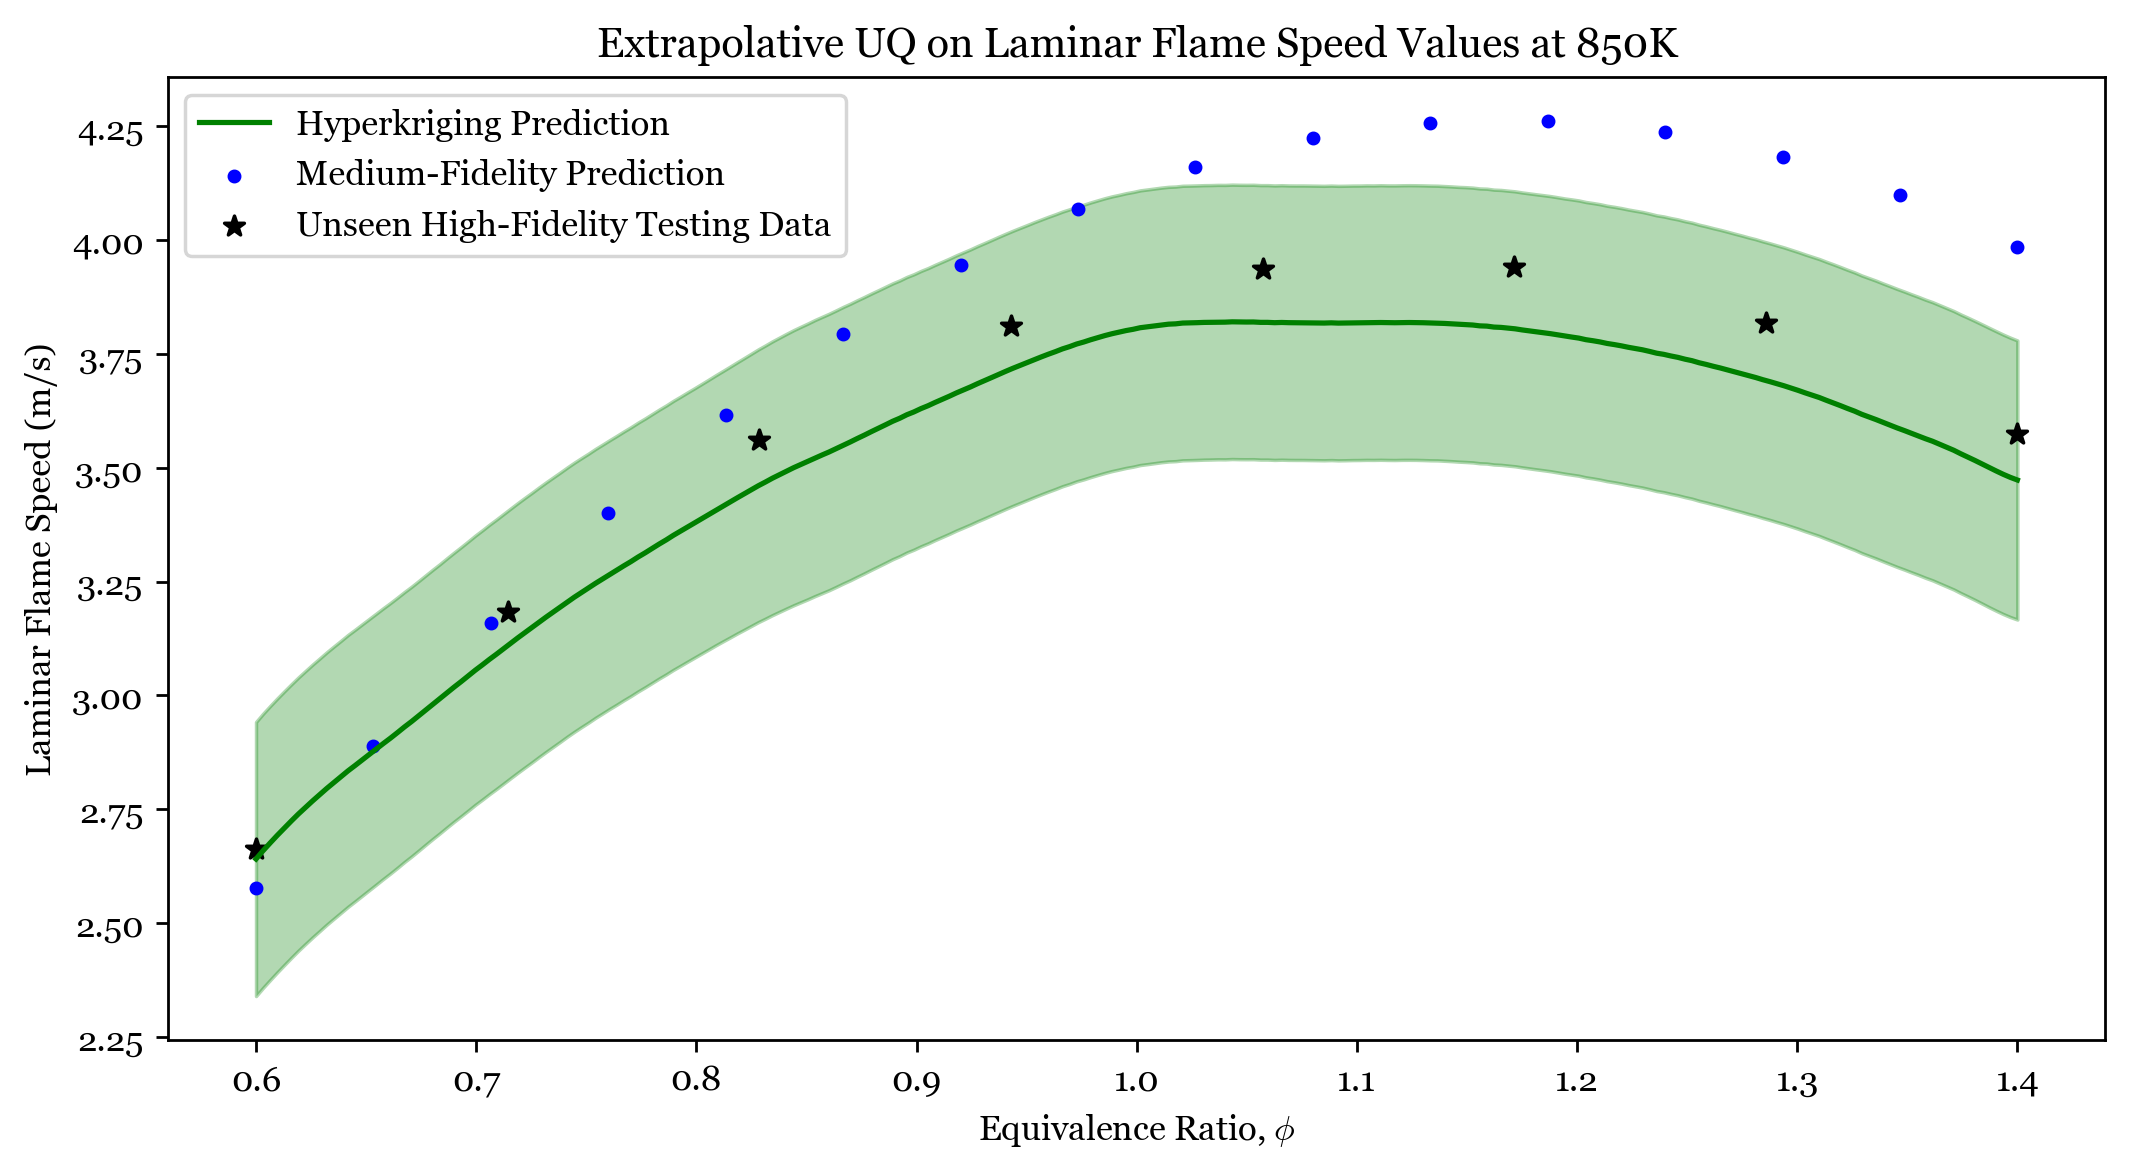

In [26]:
plt.figure(figsize=(10,5),dpi = 250)

# Plotting the Hyperkriging predictions with uncertainty estimates
plt.plot(scaler.inverse_transform(Xtest)[:,0], jnp.exp(mean).ravel(), color = 'green', label = 'Hyperkriging Prediction')
plt.fill_between(scaler.inverse_transform(Xtest)[:,0], jnp.exp(mean).ravel()-conf, jnp.exp(mean).ravel() + conf, color = 'green', alpha = 0.3)

# Plotting the Fidelity-3 training data for comparison 
inds = (scaler.inverse_transform(data_dict[3]['X'])[:,1] == test_temp) 
Xsim, Ysim = data_dict[3]['X'][inds,:], data_dict[3]['Y'][inds]
plt.scatter(scaler.inverse_transform(Xsim)[:,0], jnp.exp(Ysim), marker = '.', color = 'blue', label = 'Medium-Fidelity Prediction')

# Plotting the unseen high-fidelity testing data 
plt.scatter(Xtrue[:,0], jnp.exp(Ytrue), marker = '*', color = 'black', label = "Unseen High-Fidelity Testing Data")

# Plot labeling 
plt.title("Extrapolative UQ on Laminar Flame Speed Values at %dK" % (test_temp))
plt.xlabel("Equivalence Ratio, $\phi$")
plt.ylabel("Laminar Flame Speed (m/s)")
plt.legend()